<a href="https://colab.research.google.com/github/rosacarla/Praticas-em-PLN/blob/main/%5BLLMs%5D_Respondendo_perguntas_sobre_arquivos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Como criar um chatGPT para seus próprios arquivos?
Nesta atividade você verá como utilizar o **LangChain** para integrar uma **busca semântica** e **LLMs** para criação de um chatbot para responder perguntas referentes à uma coleção de arquivos. Neste exemplo utilizaremos algumas obras de Machado de Assis que convenientemente já estão disponíveis na biblioteca NLTK.

Recomendo acesso à [documentação](https://python.langchain.com/) para conhecer todos os recursos da ferramenta.

### 1) Instalar as dependências
Esta ação pode demorar alguns minutos.

In [ ]:
!pip install langchain
!pip install python-magic
!pip install unstructured
!pip install openai
!pip install tiktoken
!pip install faiss-cpu

In [ ]:
# Instala biblipteca Langchain Community
!pip install langchain-community

### 2) Importar as bibliotecas necessárias

In [4]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import OpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import DirectoryLoader
import magic
import os
import nltk
from nltk.corpus import machado
nltk.download('machado')

[nltk_data] Downloading package machado to /root/nltk_data...


True

### 3) Definir sua chave de acesso à API da OpenAI

Como vamos acessar a API da OpenAI para geração dos embeddings e acesso ao modelo conversacional, é necessária a utilização de uma chave, fornecida nas [configurações de sua conta](https://platform.openai.com/account/api-keys). A execução deste exemplo exige cadastro de informações financeiras junto a OpenAI, pois o acesso a API tem custos. Porém, na criação da conta geralmente lhe são dados [$5 de créditos para testar](https://openai.com/pricing) (quantia mais que suficiente para execução deste código).

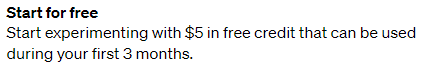

> **DICA**: *Ao criar sua chave, guarde-a em um local seguro, pois a plataforma não o deixará visualizá-la novamente após a criação.*

O LangChain também permite que utilizemos modelos próprios para geração dos embeddings e QA. Aqui utilizamos a API da OpenAI por mera conveniência.

> **DICA**: *Geralmente é uma boa prática construir sua primeira versão da aplicação conversacional baseada na API da OpenAI, seja no GPT 3.5 ou GPT 4, para depois desenvolver/ajustar seus próprios modelos, caso necessário.*



In [ ]:
openai_api_key = os.getenv("OPENAI_API_KEY", "COLOQUE SUA API KEY AQUI")

### 4) Carregar documentos e separá-los em textos menores
Precisamos que os documentos sejam separados em textos menores para que primeiro busquemos os trechos de texto que contém a resposta de nossa pergunta, para depois passá-lo ao modelo conversacional como input para ele encontrar a informação necessária e dar a resposta.

> **IMPORTANTE**: *Existem certas limitações de tamanho de entrada nos LLMs, além disso, quanto mais texto passamos para API, maior o custo. Por este motivo vamos limitar este exemplo em algumas poucas obras de Machado de Assis.*

> **OBS:**: *Você pode verificar os títulos das obras de Machado de Assis no NLTK através de* ```machado.readme()```.



In [ ]:
# Define um diretório para armazenar as obras
target_folder = "machado"
if (not os.path.exists(target_folder)):
  os.mkdir(target_folder)

# Define quais obras desejamos utilizar - aqui deixamos "Memórias Póstumas de Brás Cubas", "Quincas Borba" e "Dom Casmurro"
file_paths  = ['romance/marm05.txt', 'romance/marm07.txt', 'romance/marm08.txt']
# Caso queira todas obras, pode descomentar a linha abaixo, lembrando que os processamentos podem ficar mais lentos e os custos também aumentam caso utilize a API da OpenAI
#file_paths = machado.fileids()

# Percorre corpora de livros de Machado de Assis do NLTK
for file_path in file_paths:

  # Obtém conteúdo do livro
  content = machado.raw(file_path)

  # Define nome do arquivo de destino
  copy_file_path = target_folder + "/" + file_path.split("/")[-1]

  # Escreve o conteúdo do livro em um arquivo dentro da pasta "machado"
  with open(copy_file_path, 'w') as copy_file:
    copy_file.write(content)

In [ ]:
# Define o diretório onde estão dos arquivos, e define que deve abrir apenas arquivos com a extensão ".txt"
loader = DirectoryLoader('machado/', glob='**/*.txt')

In [ ]:
# Transforma os arquivos em documentos do LangChain
documents = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Define o tamanho dos textos menores que criaremos a partir dos documentos (1000 caracteres cada)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)

In [ ]:
# Efetua a separação dos documentos em textos menores
texts = text_splitter.split_documents(documents)

### 5) Transformar os textos em embeddings (vetores numéricos)
Neste ponto pegamos todos os textos que temos, transformamos eles em embeddings e armazenamos para que possamos efetuar buscas nos vetores numéricos depois.

In [ ]:
# Obtém modelo de criação de embeddings da OpenAI (aqui poderíamos utilizar qualquer outro modelo - Ex.: https://python.langchain.com/docs/modules/data_connection/text_embedding/integrations/huggingfacehub)
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [ ]:
# Armazena embeddings para uma busca posterior (há vários "vector stores" possíveis de se utilizar, aqui vamos de FAISS - Ex.: https://python.langchain.com/docs/modules/data_connection/vectorstores/)
docsearch = FAISS.from_documents(texts, embeddings)

### 6) Carregar o LLM conversacional
Aqui definimos qual modelo conversacional queremos utilizar. Vamos carregar algum modelo disponível na própria API da OpenAI, mas você poderia selecionar  um modelo próprio ou algum disponibilizado no [HuggingFace](https://python.langchain.com/docs/modules/model_io/models/llms/integrations/huggingface_hub), por exemplo.

In [ ]:
# Carrega LLM da OpenAI
llm = OpenAI(openai_api_key=openai_api_key)

### 7) Definir o recuperador de informação (Retriever)
Neste momento definimos o LLM conversacional que instanciamos anteriormente, como o recuperador irá enviar a pergunta ao modelo, e onde estão os embeddings para busca dos textos relevantes.

No caso do ```chain_type='stuff'```, é como se o LangChain enviasse o prompt a seguir para o modelo conversacional, substituindo o ```{context}``` pelos textos encontrados na busca, e o ```{question}``` pela pergunta feita pelo usuário.

```
Use as seguintes partes do contexto para responder à pergunta dos usuários.
Se você não souber a resposta, apenas diga que não sabe, não tente inventar uma resposta.
{context}
{question}
```

In [ ]:
# Cria o retriever
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=docsearch.as_retriever())

### 8) Enviar pergunta ao chatbot
Para enviar perguntas ao chatbot, basta enviá-la ao Retriever criado.

In [ ]:
# Envia o prompt ao chatbot
#query = "Quem é o amor de Bentinho em Dom Casmurro?"
#query = "Quem é Capitu em Dom Casmurro?"
query = "Como Bentinho ganhou a alcunha de Dom Casmurro?"
qa.run(query)

' Bentinho ganhou a alcunha de Dom Casmurro depois que ele adormeceu durante a recitação de versos por um rapaz no trem e o rapaz ficou amuado.'

#### E se eu quiser saber quais textos foram utilizados para o LLM dar a resposta?

In [ ]:
# Cria um retriever com a opção "return_source_documents=True"
qa = RetrievalQA.from_chain_type(llm=llm,
                                chain_type="stuff",
                                retriever=docsearch.as_retriever(),
                                return_source_documents=True)
#query = "Quem é o amor de Bentinho em Dom Casmurro?"
#query = "Quem é Capitu em Dom Casmurro?"
query = "Como Bentinho ganhou a alcunha de Dom Casmurro?"
result = qa({"query": query})

In [ ]:
# Mostra resposta do prompt
result['result']

' Bentinho foi alcunhado Dom Casmurro por um rapaz que encontrou no trem da Central. O rapaz havia recitado versos para Bentinho, mas como Bentinho estava cansado e fechou os olhos, o rapaz interrompeu a leitura e ficou amuado. Por isso, ele começou a dizer nomes feios de Bentinho e acabou por lhe dar a alcunha de Dom Casmurro.'

In [ ]:
# Mostra os textos que foram utilizados na produção da resposta
result['source_documents']

[Document(page_content='Romance, Dom Casmurro, 1899\n\nDom Casmurro\n\nTexto de referência:\n\nObras Completas de Machado de Assis, vol. I,\n\nNova Aguilar, Rio de\n\nJaneiro, 1994.\n\nPublicado originalmente pela Editora Garnier, Rio de Janeiro, 1899.\n\nCAPÍTULO PRIMEIRO\n\nDO TÍTULO\n\nUma noite destas, vindo da cidade para o Engenho Novo, encontrei no trem da Central um rapaz aqui do bairro, que eu conheço de vista e de chapéu. Cumprimentou-me, sentou-se ao pé de mim, falou da Lua e dos ministros, e acabou recitando-me versos. A viagem era curta, e os versos pode ser que não fossem inteiramente maus. Sucedeu, porém, que, como eu estava cansado, fechei os olhos três ou quatro vezes; tanto bastou para que ele interrompesse a leitura e metesse os versos no bolso.\n\n\x97 Continue, disse eu acordando.\n\n\x97 Já acabei, murmurou ele.\n\n\x97 São muito bonitos.', metadata={'source': 'machado/marm08.txt'}),
 Document(page_content="Vi-lhe fazer um gesto para tirá-los outra vez do bolso, m

### Pontos importantes


*   Provavelmente o chatGPT por si só já conseguiria responder a perguntas sobre as obras de Machado de Assis, visto que foi treinado em muitos textos acerca das obras. Para verificar todo o potencial da solução, **faça testes em uma coleção de documentos privada**, que contenha informações não incluídas na construção dos modelos GPT.
*   Este agente conversacional é baseado na recuperação de informações e busca semântica, portanto, **a assertividade do mesmo depende muito do sucesso na seleção de documentos relevantes** que serão inputados no contexto do modelo (i.e., *in-context learning*)
* Caso tenha ficado com dúvidas da teoria por trás da busca semântica, acesse [este link](https://txt.cohere.com/what-is-semantic-search/)
* O LangChain é uma ferramenta muito completa para construção de agentes conversacionais na era dos LLMs, e possui integração com os mais diversos serviços e LLMs (tente adaptar este código para não utilizar mais os modelos da OpenAI, que tem custo de execução - esta execução não deve gastar mais que alguns centavos de dólar)
* Por outro lado, utilizar os serviços da OpenAI pode ser um excelente ponto de partida para construção de um MVP de produto conversacional.



### Referências e Material complementar

*   [LangChain Youtube Playlist by Greg Kamradt](https://www.youtube.com/watch?v=_v_fgW2SkkQ&list=PLqZXAkvF1bPNQER9mLmDbntNfSpzdDIU5&index=1)
*   [LangChain Python Documentation](https://python.langchain.com/)
* [O que é busca semântica?](https://txt.cohere.com/what-is-semantic-search/)

Este notebook foi produzido por Prof. [Lucas Oliveira](http://lattes.cnpq.br/3611246009892500).